# Formula E analysis

In [5]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.special import softmax
import emoji
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import numpy as np
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [2]:
# Read the FormulaE.xlsx file from one directory above the current script's location
df = pd.read_excel('../FormulaE.xlsx')

# Display the summary statistics of the DataFrame to get an overview of the data#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      215 non-null    object
 1   Username   214 non-null    object
 2   Comment    215 non-null    object
 3   Date       215 non-null    object
 4   LikeCount  112 non-null    object
dtypes: object(5)
memory usage: 8.5+ KB


## Sentimental Analysis

### Method 1: Vader

In [3]:
# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jocelyn/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Analyze the sentiment of the sentence 'I am not happy!'
score = sia.polarity_scores('I am not happy!')
score

{'neg': 0.622, 'neu': 0.378, 'pos': 0.0, 'compound': -0.509}

In [5]:
# Retrieve the compound sentiment score from the analysis results
score['compound']

-0.509

In [6]:
# Access the 'Comment' column of the DataFrame
df.Comment

0      By far the best looking Formula E team this se...
1                            Splendid performance  💕💕🖤🖤🔱
2      Grande Maserati vero made in Italy in formula ...
3      Con Maserati ho un rapporto fantastico da anni...
4      Finalmente Maserati torna a competere seriamen...
                             ...                        
210                                            Stupenda 
211                                                   💙🖤
212                                             LFG  🔌🔌🔌
213                           See you all in january  💙🖤
214              Hey hey testing is coming up next week 
Name: Comment, Length: 215, dtype: object

In [7]:
# Initialise an empty list to store the sentiment values
emotionVader =[]

# Loop through each comment in the DataFrame
for i in df.Comment:
    # Perform sentiment analysis and only retrieve the 'compound' score
    compound= sia.polarity_scores(i)['compound']
    
    # Check if the compound score is positive
    if compound>0:
        # Append 1 to indicate a positive comment
        emotionVader.append(1)
    
    else:
        # Append 0 to indicate a negative or neutral comment
        emotionVader.append(0)
    

In [8]:
# Add the emotionVader list as a new column 'EmotionVader' in the DataFrame
df['EmotionVader'] = emotionVader

# Display the updated DataFrame with the new 'EmotionVader' column
df

,Title,Username,Comment,Date,LikeCount,EmotionVader
0,Maserati Tipo Folgore - First look from Masera...,@SultanNizi3000GT,By far the best looking Formula E team this se...,8 months ago,3 likes,1
1,Maserati Tipo Folgore - First look from Masera...,@jeevanvishnu1594,Splendid performance 💕💕🖤🖤🔱,8 months ago,NaN,1
2,Maserati Tipo Folgore - First look from Masera...,@alessandrocorradini2216,Grande Maserati vero made in Italy in formula ...,8 months ago,NaN,0
3,Maserati Tipo Folgore - First look from Masera...,@racingtpmotorsport-technique,Con Maserati ho un rapporto fantastico da anni...,8 months ago,NaN,0
4,Maserati Tipo Folgore - First look from Masera...,@Marcelloso,Finalmente Maserati torna a competere seriamen...,8 months ago,NaN,0
...,...,...,...,...,...,...
210,Introducing the Maserati Tipo Folgore Gen3 For...,@giuseppefanelli4619,Stupenda,8 months ago,NaN,0
211,Introducing the Maserati Tipo Folgore Gen3 For...,@mustafaengin3624,💙🖤,8 months ago,NaN,0
212,Introducing the Maserati Tipo Folgore Gen3 For...,@simeonv5303,LFG 🔌🔌🔌,8 months ago,NaN,0
213,Introducing the Maserati Tipo Folgore Gen3 For...,@migueljurado9219,See you all in january 💙🖤,8 months ago,NaN,0


In [9]:
# Count the frequency of each unique value in the 'EmotionVader' column and store it in emotionCount
emotionCount = df['EmotionVader'].value_counts()

# Display the counts of each unique emotion value
emotionCount

EmotionVader
0    125
1     90
Name: count, dtype: int64

### Method 2: Roberta Pretrained Model

In [1]:
# Import libraries
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [2]:
# Specify the pre-trained model to use for sentiment analysis
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

# Initialize the tokenizer from the pre-trained model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Initialize the sequence classification model from the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [6]:
df = pd.read_excel('../FormulaE.xlsx')

# Iterate through each comment in the DataFrame
for i in df.Comment:
    # Tokenize the comment and prepare it for the model
    encodedText = tokenizer(i, return_tensors='pt')
    
    # Get the sentiment scores using the model
    output = model(**encodedText)
    
    # Extract and detach the scores from the model's output and convert to numpy array
    scores = output[0][0].detach().numpy()
    
    # Apply the Softmax function to the scores to get probabilities
    scores = softmax(scores)
    
    # Create a dictionary to store the sentiment probabilities
    scoresDict = {
        'roberta_neg' : scores[0],  # Negative sentiment probability
        'roberta_neu' : scores[1],  # Neutral sentiment probability
        'roberta_pos' : scores[2]   # Positive sentiment probability
    }

# Display the sentiment scores for the last comment in the DataFrame
print(scoresDict)


{'roberta_neg': 0.025792567, 'roberta_neu': 0.85818154, 'roberta_pos': 0.11602589}


In [7]:
# Initialise an empty list to store the sentiment values based on RoBERTa model
emotionRoberta = []

# Loop through each comment in the DataFrame
for i in df.Comment:
    # Tokenise the comment and prepare it for the model
    encodedText = tokenizer(i, return_tensors='pt')
    
    # Get the sentiment scores using the model
    output = model(**encodedText)
    
    # Extract and detach the scores from the model's output and convert to numpy array
    scores = output[0][0].detach().numpy()
    
    # Apply the Softmax function to the scores to get probabilities
    scores = softmax(scores)
    
    # Calculate a compound score based on the probabilities for negative and positive sentiments
    compoundScore = scores[0] * (-1) + scores[2]

    # Classify the comment as positive or negative based on the compound score
    if compoundScore > 0:
        # Append 1 to indicate a positive comment
        emotionRoberta.append(1)
    else:
        # Append 0 to indicate a negative comment
        emotionRoberta.append(0)


In [8]:
# Add the 'emotionRoberta' list as a new column 'EmotionRoberta' to the DataFrame
df['EmotionRoberta'] = emotionRoberta

# Count the frequency of each unique value in the 'EmotionRoberta' column and store it in 'emotionCount'
emotionCount = df['EmotionRoberta'].value_counts()

# Display the counts of each unique value in the 'EmotionRoberta' column
emotionCount


EmotionRoberta
1    137
0     78
Name: count, dtype: int64

In [9]:
# Save the updated DataFrame to an Excel file named 'RobertaSentimentalFormulaE.xlsx'
df.to_excel('RobertaSentimentalFormulaE.xlsx')


In [10]:
# Initialize a list of all emojis
emojiList = list(emoji.EMOJI_DATA.keys())

# Initialize a counter for emojis that are not identified by the tokenizer
cnt = 0

# Loop through each emoji to check its tokenization
for e in emojiList:
    # Tokenize and decode the emoji, removing special tokens like </s>
    tokenized = tokenizer.decode(tokenizer.encode(e)).strip("</s>").strip()
    
    # Check if the original emoji is not present in the tokenized form
    if e not in tokenized:
        cnt += 1  # Increment the counter if the emoji is not identified

# Calculate and print the proportion of emojis not identified by the tokenizer
print(f"{cnt/len(emojiList)} of the emojis are not identified by this tokenizer.")


0.0 of the emojis are not identified by this tokenizer.


In [13]:
# Load the Excel file 'RobertaSentimentalFormulaE.xlsx' into a DataFrame after cleaning
df = pd.read_excel('../RobertaSentimentalFormulaEfinal.xlsx')


## Visualisation

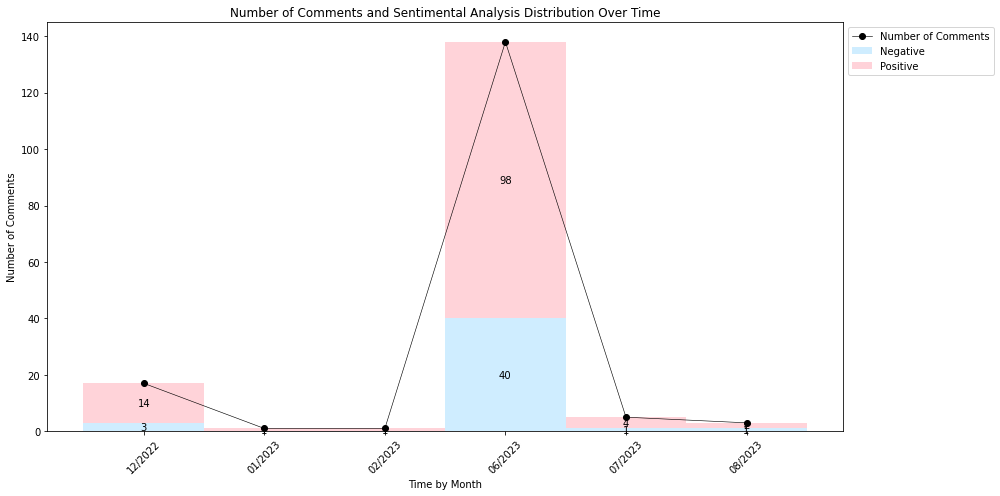

In [14]:
# Data Preprocessing: Create a 'MonthYear' column from 'ActualDate'
df['MonthYear'] = df['ActualDate'].dt.strftime('%m/%Y')

# Group by 'MonthYear' to count the total number of comments
totalComments = df.groupby('MonthYear').size().reset_index(name='Number_of_Comments')

# Reordering code to make '12/2022' the first entry
uniqueDate = totalComments['MonthYear'].tolist()
uniqueDate.remove('12/2022')
sortedDate = sorted(uniqueDate, key=lambda x: (int(x.split('/')[1]), int(x.split('/')[0])))
sortedDate = ['12/2022'] + sortedDate
totalComments = totalComments.set_index('MonthYear').loc[sortedDate].reset_index()

# Create the DataFrame for the stacked bar chart
stackedBarData = df.groupby(['MonthYear', 'EmotionRoberta']).size().reset_index(name='Number_of_Comments')
stackedBarDataPivot = stackedBarData.pivot(index='MonthYear', columns='EmotionRoberta', values='Number_of_Comments')
stackedBarDataPivot = stackedBarDataPivot.reindex(totalComments['MonthYear'])  # Align dates

# Data Visualization
fig, ax1 = plt.subplots(figsize=(14, 7))

# Stacked Bar Chart for EmotionRoberta
colors = ["#B0E2FF","#FFB6C1"]
stackedBarDataPivot = stackedBarDataPivot.reindex(totalComments['MonthYear'])  # Align dates
bottomValues = np.zeros(len(stackedBarDataPivot))

for idx, column in enumerate(stackedBarDataPivot.columns):
    bars = ax1.bar(stackedBarDataPivot.index, stackedBarDataPivot[column].fillna(0), bottom=bottomValues, color=colors[idx], alpha=0.6,label=f'EmotionRoberta: {column}', width=1.0)
    bottomValues += stackedBarDataPivot[column].fillna(0)

    # Add the emotion counts to the bars
    for bar in bars:
        height = bar.get_height()
        position = bar.get_y()
        if height > 0:  # To avoid placing labels on bars with height 0
            ax1.text(bar.get_x() + bar.get_width()/2, position + height/2, str(int(height)), ha='center', va='center', fontsize=10)

# Time-Series Line Plot for Number of Comments
ax1.plot(totalComments['MonthYear'].values, totalComments['Number_of_Comments'].values, marker='o', linestyle='-', color='black', linewidth=0.6, zorder=3)
ax1.set_xlabel('Time by Month')
ax1.set_ylabel('Number of Comments')
ax1.set_title('Number of Comments and Sentimental Analysis Distribution Over Time')
ax1.grid(False)

# Setting labels and title for the y-axis
ax1.legend(['Number of Comments','Negative', 'Positive'], loc='upper left', bbox_to_anchor=(1, 1))

# Final layout adjustments
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()


## Topic Modeling

In [15]:
# Load the English language small model of SpaCy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

# Preprocesses the text by converting to lowercase, splitting, removing non-alphanumeric words, and filtering out stop words
def preprocess_text(text):
    return ' '.join([word for word in text.lower().split() if word.isalpha() and word not in sw_spacy and len(word) > 2])

# Filter the data for June 2023
dfJune = df[df['MonthYear'] == '06/2023']

# Apply text preprocessing
dfJune['ProcessedComment'] = dfJune['Comment'].astype(str).apply(preprocess_text)

# Transform into a bag of words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(dfJune['ProcessedComment'])

# Train the LDA model
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(data_vectorized)

# Display the top 10 words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))


Topic 1:
racing great max best formula gunther big pretty baswedan anis
Topic 2:
win good formula race like job wow santiago talking nice
Topic 3:
formula like broken think max racing maserati race series got
Topic 4:
jakarta highlights free practice gunther love amazing nissan formula indonesia
Topic 5:
race team spot round congrats different know going tamiya racing


/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_91243/4105457483.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfJune['ProcessedComment'] = dfJune['Comment'].astype(str).apply(preprocess_text)
